# Imports and Device

In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F

import math
import time

In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


# Load the data

In [3]:
root_path = "/scratch/04703/sravula/UTAFSDataNew/new_data"
chip_num = 0

In [4]:
import utils

data_dict = utils.grab_chip_data(root_path, chip_num, resample=True)

In [5]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs', 'og_matrix', 'og_freqs'])

In [6]:
print(data_dict['gt_matrix'].shape)
print(data_dict['vf_matrix'].shape)
print(data_dict['y_matrix'].shape)
print(data_dict['og_matrix'].shape)

print(data_dict['gt_freqs'].shape)
print(data_dict['y_freqs'].shape)
print(data_dict['og_freqs'].shape)

(1024, 2, 2, 2)
(1000, 2, 2, 2)
(8, 2, 2, 2)
(1000, 2, 2, 2)
(1024,)
(8,)
(1000,)


In [7]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])
og_data = utils.matrix_to_sparams(data_dict['og_matrix'])

In [8]:
print(vf_data.shape)
print(gt_data.shape)
print(y_data.shape)
print(og_data.shape)

(3, 2, 1000)
(3, 2, 1024)
(3, 2, 8)
(3, 2, 1000)


In [9]:
og_freqs = data_dict['og_freqs']
gt_freqs = data_dict['gt_freqs']

In [10]:
print(og_freqs.shape)
print(gt_freqs.shape)

(1000,)
(1024,)


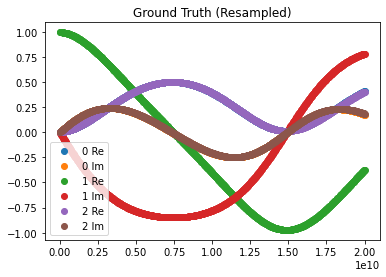

In [11]:
n_sparams = gt_data.shape[0]

plt.figure()
for i in range(n_sparams):
    plt.scatter(gt_freqs, gt_data[i,0,:].squeeze(), label=str(i)+" Re")
    plt.scatter(gt_freqs, gt_data[i,1,:].squeeze(), label=str(i)+" Im")
plt.legend()
plt.title("Ground Truth (Resampled)")
plt.show()

## Grab some measurements

In [12]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full]
LENGTH = len(gt_freqs)
M = 10

In [13]:
kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, LENGTH, M)

In [14]:
print(LENGTH)
print(M)
print(len(kept_inds))
print(len(missing_inds))

1024
10
11
1013


## Make the final data

In [15]:
x = torch.from_numpy(gt_data).type(torch.float32)
x = x.view(-1, LENGTH).unsqueeze(0)

In [16]:
print(x.shape)

torch.Size([1, 6, 1024])


In [17]:
y = torch.clone(x)[:, :, kept_inds]

In [18]:
print(y.shape)

torch.Size([1, 6, 11])


## Visualize the data and observations

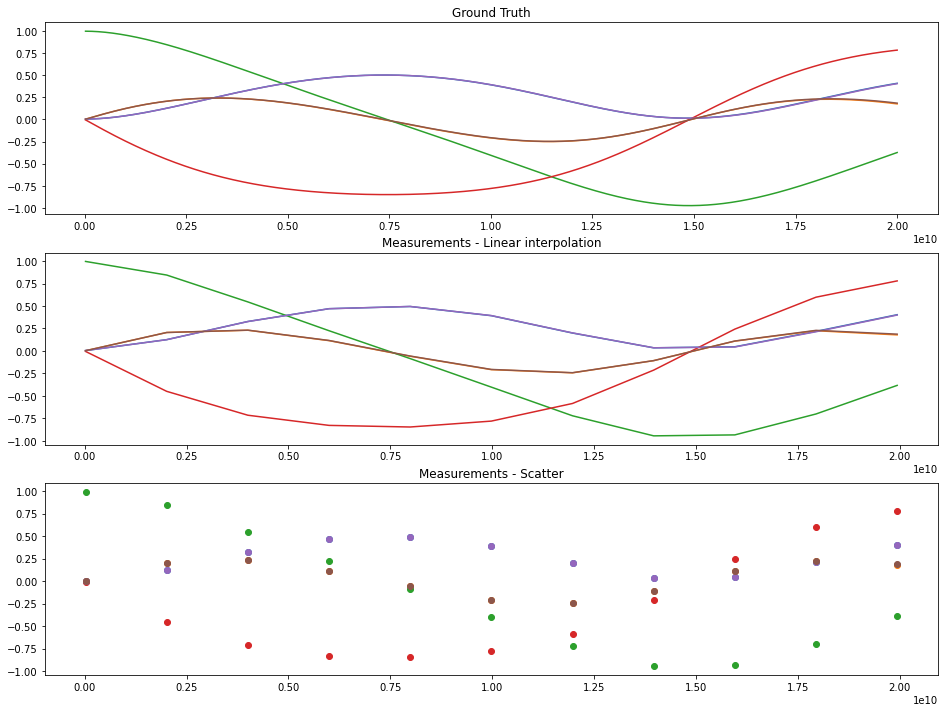

In [19]:
fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        axes[0].plot(gt_freqs, x[j,i,:].flatten())
axes[0].set_title("Ground Truth")

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        axes[1].plot(gt_freqs[kept_inds], y[j,i,:].flatten())
axes[1].set_title("Measurements - Linear interpolation")

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        axes[2].scatter(gt_freqs[kept_inds], y[j,i,:].flatten())
axes[2].set_title("Measurements - Scatter")

plt.show()

# Set up the network

In [20]:
LR = 1e-3 # learning rate
NUM_ITER = 10000 # number iterations

NZ = y.shape[1]
NGF = 64

BS = y.shape[0]
NC = y.shape[1]

In [21]:
from models import ENC_DEC

KERNEL_SIZE = [17, 15, 11, 7, 3]

net = ENC_DEC(bs=BS, nz=NZ, ngf=NGF, output_size=LENGTH, nc=NC, kernel_size=KERNEL_SIZE)
net = net.to(device)

In [22]:
test_out = net.forward_with_z()
print(test_out.shape)

torch.Size([1, 6, 1024])


/scratch/04703/sravula/conda_local/envs/devito-base/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [23]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  9405184


# (Testing) First fit linear interpolation before fitting the measurements

In [24]:
import scipy

y_np = y.cpu().detach().numpy()

Interpolate = scipy.interpolate.interp1d(kept_inds, y_np, fill_value='extrapolate')

In [25]:
y_interp = Interpolate(np.arange(LENGTH))

print(y_interp.shape)

(1, 6, 1024)


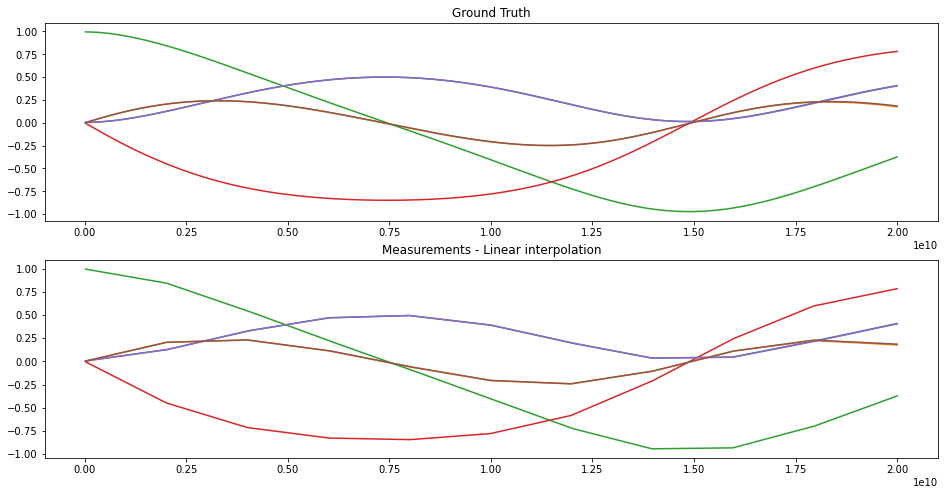

In [26]:
fig, axes = plt.subplots(2,1, figsize=(16, 8))
axes = axes.flatten()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        axes[0].plot(gt_freqs, x[j,i,:].flatten())
axes[0].set_title("Ground Truth")

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        axes[1].plot(gt_freqs, y_interp[j,i,:].flatten())
axes[1].set_title("Measurements - Linear interpolation")

plt.show()

In [27]:
criterion = torch.nn.MSELoss()
criterion = criterion.to(device)

In [28]:
net = net.train()

optim = torch.optim.Adam(net.parameters(), lr=LR)

train_losses = []

y_interp = torch.from_numpy(y_interp).type(torch.float32)
y_interp = y_interp.to(device)

In [29]:
tic = time.time()
for i in range(1000):
    net.perturb_noise(0.01) 
    
    optim.zero_grad()
    
    out = net.forward_with_z()
    train_loss = criterion(out, y_interp)
    
    train_loss.backward()
    optim.step()
    
    with torch.no_grad():
        train_losses.append(train_loss.item())

        if (i+1)%100 == 0 or i == 0:
            toc = time.time()
            print("ITER ", str(i))
            print("TIME: ", str(toc - tic))
            print()

/scratch/04703/sravula/conda_local/envs/devito-base/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


ITER  0
TIME:  0.027257680892944336

ITER  99
TIME:  1.5278973579406738

ITER  199
TIME:  3.019028902053833

ITER  299
TIME:  4.5243377685546875

ITER  399
TIME:  6.014238119125366

ITER  499
TIME:  7.517321348190308

ITER  599
TIME:  9.02364444732666

ITER  699
TIME:  10.50960087776184

ITER  799
TIME:  12.023003339767456

ITER  899
TIME:  13.53064775466919

ITER  999
TIME:  15.010897159576416



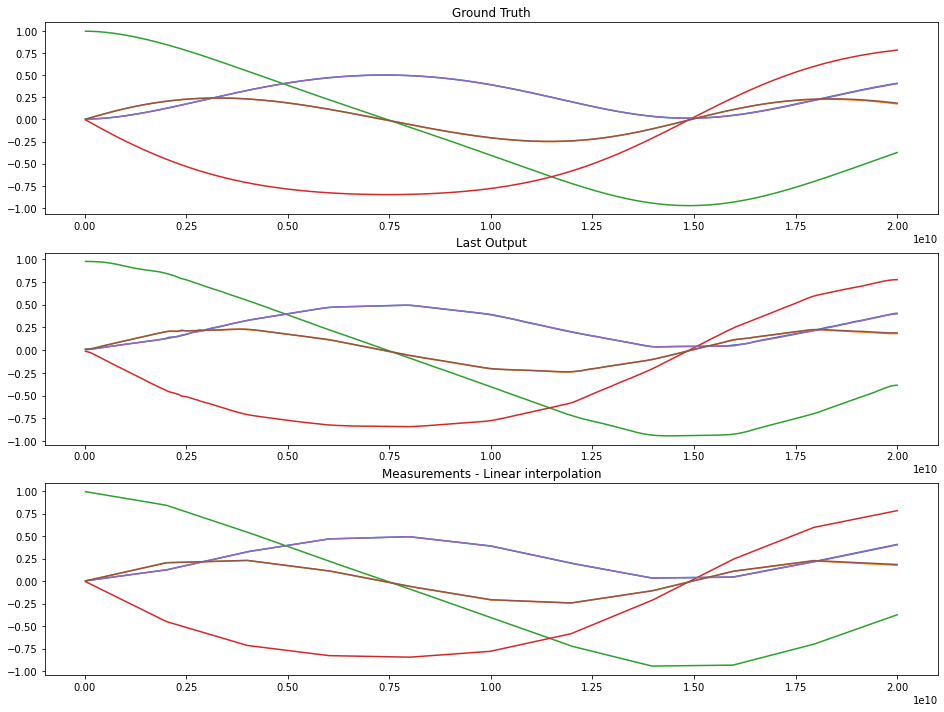

In [30]:
out = out.detach().cpu().numpy()

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        axes[0].plot(gt_freqs, x[j,i,:].cpu().flatten())
axes[0].set_title("Ground Truth")

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        axes[1].plot(gt_freqs, out[j,i,:].flatten())
axes[1].set_title("Last Output")

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        axes[2].plot(gt_freqs, y_interp[j,i,:].cpu().flatten())
axes[2].set_title("Measurements - Linear interpolation")

plt.show()

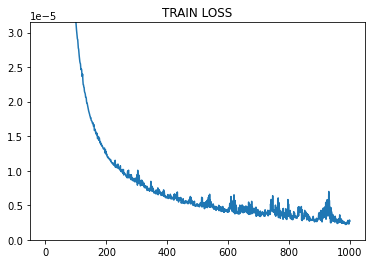

In [31]:
max_idx = 100

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

# Run

In [32]:
criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds)
criterion = criterion.to(device)

In [33]:
net = net.train()

optim = torch.optim.Adam(net.parameters(), lr=LR)

train_losses = []
test_mses = []
test_maes = []
outputs = []

x = x.to(device)
y = y.to(device)

In [ ]:
tic = time.time()
for i in range(NUM_ITER):
    net.perturb_noise(0.01) 
    
    optim.zero_grad()
    
    out = net.forward_with_z()
    train_loss = criterion(out, y)
    
    train_loss.backward()
    optim.step()
    
    with torch.no_grad():
        outputs.append(out.detach().clone().cpu())
        train_losses.append(train_loss.item())
        
        test_mse = nn.MSELoss()(out, x)
        test_mses.append(test_mse.item())
        
        test_mae = nn.L1Loss()(out, x)
        test_maes.append(test_mae.item())

        if (i+1)%500 == 0 or i == 0:
            toc = time.time()
            print("ITER ", str(i))
            print("TIME: ", str(toc - tic))
            print()

/scratch/04703/sravula/conda_local/envs/devito-base/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


ITER  0
TIME:  0.01837611198425293

ITER  499
TIME:  7.9482152462005615



# Plot the last and best outputs and the metrics

In [ ]:
out = outputs[-1]

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        axes[0].plot(gt_freqs, x[j,i,:].cpu().flatten())
axes[0].set_title("Ground Truth")

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        axes[1].plot(gt_freqs, out[j,i,:].flatten())
axes[1].set_title("Last Output")

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        axes[2].plot(gt_freqs[kept_inds], y[j,i,:].cpu().flatten())
axes[2].set_title("Measurements - Linear interpolation")

plt.show()

In [ ]:
max_idx = np.argmax(train_losses)

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()